In [3]:
using DelimitedFiles
using StatsBase
using Distributions
using LinearAlgebra
using Main

S = collect(1:101)# 15 is the terminal state
p4 =.4
function value_iteration(V, π)
    γ = 1   # discount factor
    θ = 1e-3 # tolerance for convergence
    while true
        δ = 0.0
        for s = 1:99   # loop through the nonterminal states
            v = V[s+1]   # old value
            A = collect(1:findmin([s,100-s])[1])
            q = zeros(length(A))
            for a in A
                q[a] = p4*(0 + γ*V[a+s+1]) + (1-p4)*(0 + γ*V[s-a+1])
            end
            V[s+1], greedy_action = findmax(q)              
            π[s+1] = greedy_action
            δ = max(δ, abs(v - V[s+1]))
        end
        if δ < θ
            break
        end
    end
    return V, π
    # output the optimal value function and a deterministic policy
end
pi =zeros(101)
V = zeros(length(S))  # will hold the value function
V[101] = 1
V, pi= value_iteration(V, pi)
println("capital 51: ", pi[52])#at capital 51
println("capital 50: ", pi[51]) #at capital 50
println("capital 49: ", pi[50]) #at capital 49

capital 51: 1.0
capital 50: 50.0
capital 49: 1.0


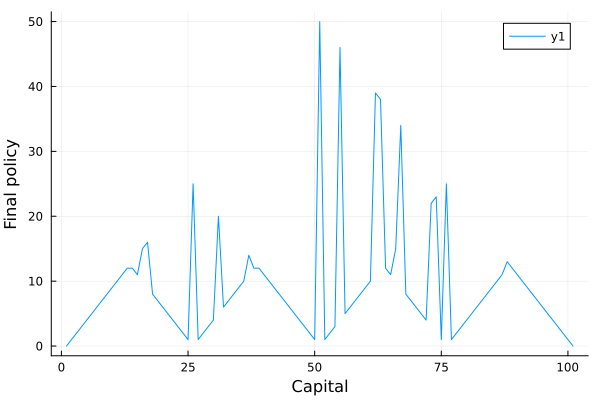

In [4]:
using Plots
α = range(1,101)
plot(α, pi[α], xlabel="Capital", ylabel="Final policy")


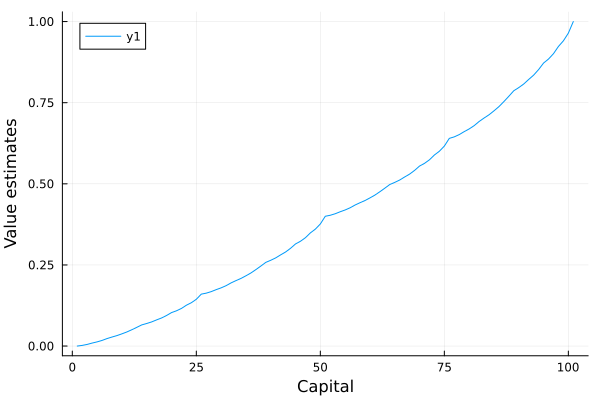

In [5]:
plot(α, V[α], xlabel="Capital", ylabel="Value estimates" )



In [6]:
# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
# solving the black jack game described in example 5.1
using Random, StatsBase

# the face values for a suit
# ace through nine, ten, jack, queen, king
# note that 1=ace
suit = vcat(1, collect(2:9), 10, 10, 10, 10)
# a deck of cards consists of four suits: diamonds, clubs, hearts, spades
deck = repeat(suit,4)
shuffle!(deck)     # a random permutation
# to simulate an infinite deck, we can sample with replacement
deal_cards(n) = sample(deck, n, replace=true)
# note that it's quite possible (in fact it's common) to have more than
# one ace in a hand, but it's not possible to have two "usable" aces.
# 1/2 = no/yes
usable_ace(hand) = (any(hand .== 1) && sum(hand) <= 11) ? 2 : 1
score(hand) = sum(hand) + (usable_ace(hand)==2 ? 10 : 0)
# simulate an episode of blackjack according to policy π
function blackjack(π, ϵ = 0.05)
    player = deal_cards(2)
    dealer = deal_cards(2)
    action = []
    while score(player) < 12
        append!(player, deal_cards(1)) 
    end
    states = [[score(player), dealer[1] ,usable_ace(player)]]
    if states[1] == 21 && states[3] == 2
        push!(action, 2)
        if score(dealer) == 21  && usable_ace(dealer) == 2
            return states, action, 0
        else
            return states, action, 1
        end
    end
    while true 
        a = π[states[length(states)][1]-11,states[length(states)][2], states[length(states)][3]]#determine the action a according to policy
        if rand() < ϵ
            if a == 1
               a=2         
            else
                a = 1
            end
        end
        if a == 2
            push!(action,a)        
            break
        else
            push!(action, a)
            append!(player, deal_cards(1))
            if score(player) > 21
                return states, action, -1.0
            else
                push!(states,[ score(player), dealer[1] , usable_ace(player)])
            
            end
        end
    end
    while score(dealer)<17                      
        append!(dealer, deal_cards(1))
    end
    if score(dealer) > 21 || states[length(states)][1]> score(dealer)
        r =1.0
    elseif states[length(states)][1]< score(dealer)
        r = -1.0
    else
        r = 0.0
    end
    return states, action, r 
end
# this is on-policy every-visit MC control because we do not check for
# 1st visits to states; however, for the game of blackjack, it's not
# possible to visit the same state twice in an episode. you could have
# an ace being counted as 11, and then later being counted as 1, but
# the indicator for a usable ace is part of the state.  also, note
# that we maintain exploration of nonoptimal actions in the function
# blackjack().
function MC!(q, qn, π, S)
    for i = 1:10e6
        i % 100000 == 0 && println("episode ", i)
        states, actions, r = blackjack(π)
        @assert(length(states) == length(actions))
        @assert( r in [-1.0, 0.0, 1.0])
        T = length(states)
        for t = 1:T
            s = states[t]
            a= actions[t]
            qn[s[1]-11, s[2], s[3],a] += 1 #updating qn
            q[s[1]-11, s[2], s[3], a] += r  #updating q    
            S[s[1]-11, s[2], s[3]], maxaction = findmax( q[s[1]-11, s[2], s[3],:]./ qn[s[1]-11, s[2], s[3], :])# find the action that maxmizes q for state s
            π[s[1]-11, s[2], s[3]] = maxaction    # update the policy greedily 
        end
    end
end

# the state space consists of
# the player's sum 12:21,
# the dealer's showing card 1:10,
# and indicator for usable ace no/yes=1/2
# for a total of 200 possible states.
# the action is hit/stick=1/2

# the initial policy is to stick when the player's sum is 20 or 21, otherwise hit
π = fill(1, (10, 10, 2))
π[9:10,:,:] .= 2           # stick when sum is 20 or 21 
q = zeros(10, 10, 2, 2)    # q(state=(player,dealer,usable), action)
qn = zeros(10, 10, 2, 2)   # to hold the number of observations
S =  zeros(10, 10, 2)
MC!(q, qn, π, S)

episode 100000.0
episode 200000.0
episode 300000.0
episode 400000.0
episode 500000.0
episode 600000.0
episode 700000.0
episode 800000.0
episode 900000.0
episode 1.0e6
episode 1.1e6
episode 1.2e6
episode 1.3e6
episode 1.4e6
episode 1.5e6
episode 1.6e6
episode 1.7e6
episode 1.8e6
episode 1.9e6
episode 2.0e6
episode 2.1e6
episode 2.2e6
episode 2.3e6
episode 2.4e6
episode 2.5e6
episode 2.6e6
episode 2.7e6
episode 2.8e6
episode 2.9e6
episode 3.0e6
episode 3.1e6
episode 3.2e6
episode 3.3e6
episode 3.4e6
episode 3.5e6
episode 3.6e6
episode 3.7e6
episode 3.8e6
episode 3.9e6
episode 4.0e6
episode 4.1e6
episode 4.2e6
episode 4.3e6
episode 4.4e6
episode 4.5e6
episode 4.6e6
episode 4.7e6
episode 4.8e6
episode 4.9e6
episode 5.0e6
episode 5.1e6
episode 5.2e6
episode 5.3e6
episode 5.4e6
episode 5.5e6
episode 5.6e6
episode 5.7e6
episode 5.8e6
episode 5.9e6
episode 6.0e6
episode 6.1e6
episode 6.2e6
episode 6.3e6
episode 6.4e6
episode 6.5e6
episode 6.6e6
episode 6.7e6
episode 6.8e6
episode 6.9e6
episode

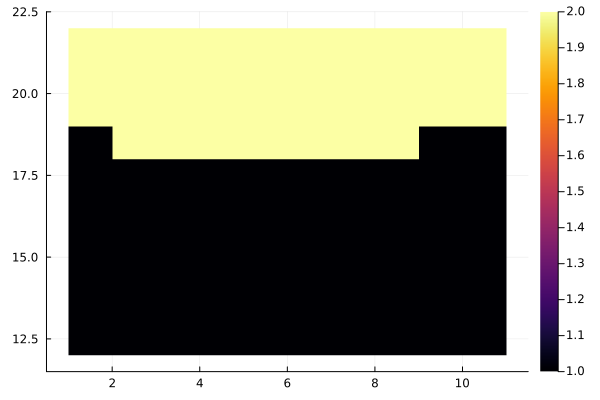

In [7]:
import Plots
x=range(1,11)
y = range(1,11)
Plots.heatmap(x , y.+11, π[:, :,2]) #heatmap of usable ace x axis = dealer showing, yaxis =  player sum 12 to 21


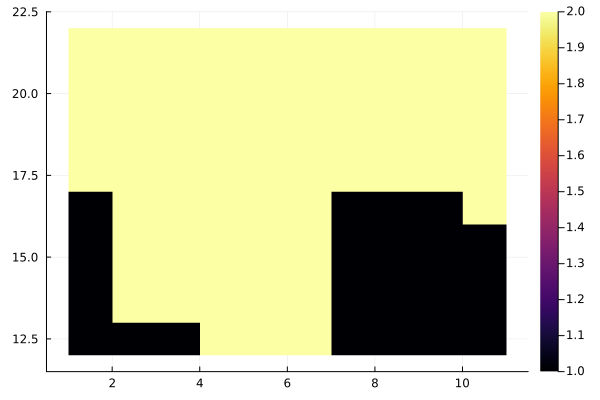

In [8]:
x = range(1,11)
y = range(1,11)
Plots.heatmap(x, y.+ 11, π[:, :,1]) #heatmap of nonusable ace

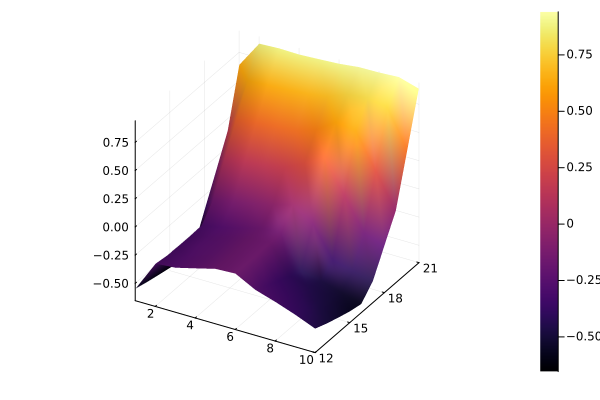

In [9]:
using Plots
# two functions named f exist. they have different signatures
y = range(1,10) #for the player 
x= range(1,10) #for the dealer
Plots.surface(x, y.+11, S[y,x,1]) #non usable ace consider x = current value showing + 11  because x is the player sum

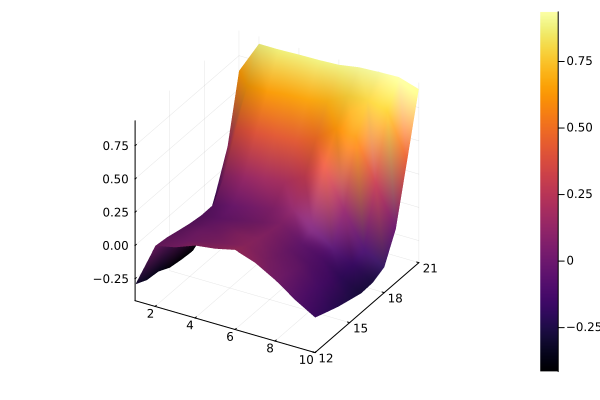

In [10]:
Plots.surface(x, y.+11, S[y,x,2])  #surface plot of the usable ace
